# DVRA Project

Name: Jeffrey Davidson

In [197]:
import numpy as np
import matplotlib.pyplot as plt
import scipy.stats as st
import scipy.optimize as opt
from yahoo_fin import stock_info
from sklearn.linear_model import LinearRegression
import pandas as pd

**1. Write a Function for calculating the Parametric VaR of DLF (40%), NTPC (20%) And HDFC Bank (40%). Take historical data for last 500 days before 1st Oct, 2019 and a 99% VaR confidence level.**

Parametric Approach assumes a parametric distribution for the returns. The assumed distribution is the normal distribution. The covariance matrix for the returns can be found using different methods. Here we will use the following approaches to calculate volatility and correlation.
1. Based on equal weights of historical data
2. Exponentially weighted Moving Average (EWMA) Method

Below function is for obtaining the covariance matrix for the return series using EWMA method. The optimal value of $\lambda$ is estimated using maximum likelihood estimation automatically. This function is used in the main code to calculate VaR.

In [155]:
class covariance_matrix_EWMA():
    def __init__(self,returns):
        self.returns = returns
        self.l_opt = self.l_optimum()
    
    def cv_update(self,x,y,l=0.94):
        cv = []
        cv.append(x[0]*y[0])
        for i in range(1,len(x)):
            cv.append(l*cv[i-1]+(1-l)*x[i-1]*y[i-1])
        return cv
    
    def cov_matrix(self,l=0.94):
        n = len(self.returns.columns)
        cv_matrix = np.empty(shape=(n,n))
        for i in range(n):
            for j in range(n):
                cv_matrix[i,j] = (self.cv_update(x=self.returns.iloc[:,i].values,
                                     y =self.returns.iloc[:,j].values,
                                     l =l)[-1])
        return cv_matrix
    
    def likelihood_fn(self,cv_matrix):
        if np.ndim(cv_matrix) >1:
            cv_det = np.linalg.det(cv_matrix)
            cv_inv = np.linalg.inv(cv_matrix)
        else:
            cv_det =cv_matrix
            cv_inv = cv_matrix
        f = lambda x: -np.matmul(np.matmul(np.transpose(x),cv_inv),x)-np.log(cv_det)
        logL = self.returns.apply(f,axis=1,raw=True)
        return np.sum(logL)*-1
    
    def obj_fn(self,l_var):
        c = self.cov_matrix(l_var)
        return self.likelihood_fn(c)
        
    def l_optimum(self):
        return opt.minimize_scalar(self.obj_fn,bounds=(0.0001,1),method ='Bounded').x
    
    def get_EWMA_covmatrix(self):
        return self.cov_matrix(self.l_opt)
                

The function for estimating the parametric VaR and Expected Shortfall using both methods is given below:

In [153]:
class model_approach():
    def __init__(self,stock_tickers,amt,start_date,end_date,EWMA=False):
        self.tickers = stock_tickers
        self.EWMA_method = EWMA
        self.amt = amt
        self.weights = amt/np.sum(amt)
        self.prices = self.get_prices(start_date,end_date)
        self.returns = self.get_returns(1)
        self.cv_matrix = self.cv_matrix()
        
    def get_prices(self,start_date,end_date):
        s = pd.DataFrame()
        for i in self.tickers:
            b = stock_info.get_data(i,start_date,end_date)['adjclose']
            s[i] =b
        return s.dropna()
    
    def get_returns(self,n):
        returns = pd.DataFrame(data = self.prices.values[n:,]/self.prices.values[:-n,]-1,
                               index = self.prices[n:].index,
                               columns = self.prices.columns)
        
        return returns
    
    def cv_matrix(self):
        if self.EWMA_method == True:
            c = covariance_matrix_EWMA(self.returns).get_EWMA_covmatrix()
        else:
            c = np.cov(self.returns,rowvar=False)
        return c
    
    def portfolio_variance(self):
        return np.matmul(np.matmul(np.transpose(self.weights),
                         self.cv_matrix),self.weights)
    
    def calculate_VaR(self,n,confidence):
        z = st.norm.ppf(1-confidence)        
        v = self.portfolio_variance()
        return z*(v*n)**0.5*np.sum(self.amt)
    
    def calculate_CVaR(self,n,confidence):
        z = st.norm.ppf(1-confidence)
        Y = self.calculate_VaR(n,confidence)
        v = self.portfolio_variance()
        return -((v*n/(2*np.pi))**0.5)*np.exp(-z**2/2)/(1-confidence)*np.sum(self.amt)
    
    def change_weights(self,amt):
        self.amt = amt
        self.weights = amt/np.sum(amt)


The following inputs need to be provided:
1. **stock_tickers** is the list of stock symbols.
2. **amt** is the amount invested in each stock
3. **start_date** and **end_date** is the range of dates for which the historical data needs to be extracted
4. **EWMA** is to specify whether the covariance matrix should be calculated from equal weights (False) or using EWMA Method (True).

The function for calculating the EWMA is given separately above.

The function automatically extracts the historical data from yahoo finance and calculates the portfolio variance for the weights given when initialized. The VaR and ES can be extracted using the methods **calculate_VaR()** and **calculate_CVaR()**.

The below code uses the functions to calculate VaR and Expected Shortfall.

In [156]:
m1 =model_approach(['DLF.NS','NTPC.NS','HDFC.NS'],[1,1,1],'2017-10-01','2019-10-01',EWMA=False)
m2 =model_approach(['DLF.NS','NTPC.NS','HDFC.NS'],[1,1,1],'2017-10-01','2019-10-01',EWMA=True)

m1 is the model used for calculating VaR using equal weightted covariance matrix. m2 is the model used for calculating VaR using EWMA method. The **amt** vector can be changed after initialization using **change_weights()**.

In [16]:
m1.prices.tail()

,DLF.NS,NTPC.NS,HDFC.NS
2019-09-24,165.536819,104.541580,2083.505371
2019-09-25,154.154617,106.130363,2024.766235
2019-09-26,160.093155,105.812607,2018.163696
2019-09-27,156.727997,106.266541,1991.459595
2019-09-30,154.006165,106.675079,1933.894287


In [23]:
m1.returns.tail()

,DLF.NS,NTPC.NS,HDFC.NS
2019-09-24,-0.002683,-0.007755,-0.014801
2019-09-25,-0.068759,0.015198,-0.028192
2019-09-26,0.038523,-0.002994,-0.003261
2019-09-27,-0.021020,0.004290,-0.013232
2019-09-30,-0.017367,0.003844,-0.028906


In [26]:
print(' Covariance matrix calculated using equal weights')
m1.cv_matrix 

 Covariance matrix calculated using equal weights


array([[7.28323480e-04, 8.13836788e-05, 1.20380620e-04],
       [8.13836788e-05, 1.97856618e-04, 3.53219371e-05],
       [1.20380620e-04, 3.53219371e-05, 2.23327210e-04]])

In [27]:
print(' Covariance matrix calculated using EWMA')
m2.cv_matrix 

 Covariance matrix calculated using EWMA


array([[7.09156302e-04, 8.57877747e-05, 1.39230412e-04],
       [8.57877747e-05, 2.04510607e-04, 2.87050337e-05],
       [1.39230412e-04, 2.87050337e-05, 2.20007969e-04]])

In [185]:
print('1-Day 99% VaR calculated using Parametric Approach (Assuming portfolio value of $1000):')
print('-----------------------------------------------------------------------------------')
print('\t\tVaR\t  ','ES')

n=1
confidence =0.99
amt_inv = 1000
weights = np.array([0.4,0.2,0.4])

m1.change_weights(weights*amt_inv)
m2.change_weights(weights*amt_inv)

print('Equal Weights',end='\t')
print(-np.round(m1.calculate_VaR(n,confidence),3),end='\t  ')
print(-np.round(m1.calculate_CVaR(n,confidence),3),end='\n')

print('EWMA',end='\t\t')
print(-np.round(m2.calculate_VaR(n,confidence),3),end='\t  ')
print(-np.round(m2.calculate_CVaR(n,confidence),3),end='\n')

1-Day 99% VaR calculated using Parametric Approach (Assuming portfolio value of $1000):
-----------------------------------------------------------------------------------
		VaR	   ES
Equal Weights	34.299	  39.295
EWMA		34.483	  39.506


**2. Use data from problem 1.) and write a function for calculating VaR using Historical Simulation.**

The function for Historical Simulation approach is given below:

The following inputs need to be provided:
1. **stock_tickers** is the list of stock symbols.
2. **amt** is the amount invested in each stock
3. **start_date** and **end_date** is the range of dates for which the historical data needs to be extracted

In [64]:
class Historical_Simulation():
    def __init__(self,stock_tickers,amt,start_date,end_date):
        self.tickers = stock_tickers
        self.amt = amt
        self.weights = amt/np.sum(amt)
        self.prices = self.get_prices(start_date,end_date)
        self.returns = self.get_returns(1)
    
    def get_prices(self,start_date,end_date):
        s = pd.DataFrame()
        for i in self.tickers:
            b = stock_info.get_data(i,start_date,end_date)['adjclose']
            s[i] =b
        return s.dropna()
    
    def get_returns(self,n):
        returns = pd.DataFrame(data = self.prices.values[n:,]/self.prices.values[:-n,]-1,
                               index = self.prices[n:].index,
                               columns = self.prices.columns)
        
        return returns
    
    def get_portfolio_returns(self,n):
        returns  = self.get_returns(n)
        return returns.apply(lambda x: np.dot(x,self.weights),axis = 1).copy()
        
    
    def calculate_VaR(self,n,confidence):
        r = self.get_portfolio_returns(n)*np.sum(self.amt)
        return np.percentile(r,q = (1-confidence)*100)
    
    def calculate_CVaR(self,n,confidence):
        r = self.get_portfolio_returns(n)*np.sum(self.amt)
        VaR = self.calculate_VaR(n,confidence)
        return np.mean(r[r<=VaR])
    
    def change_weights(self,amt):
        self.amt = amt
        self.weights = amt/np.sum(amt)
        
        

In [76]:
m3 = Historical_Simulation(['DLF.NS','NTPC.NS','HDFC.NS'],[1,1,1],'2017-10-01','2019-10-01')

In [188]:
m3.returns.tail()

,DLF.NS,NTPC.NS,HDFC.NS
2019-09-24,-0.002683,-0.007755,-0.014801
2019-09-25,-0.068759,0.015198,-0.028192
2019-09-26,0.038523,-0.002994,-0.003261
2019-09-27,-0.021020,0.004290,-0.013232
2019-09-30,-0.017367,0.003844,-0.028906


In [190]:
print('1-Day 99% VaR and ES calculated using Historical Simulation (Assuming $1000 invested in the portfolio):')
print('------------------------------------------------------------------------------------------------------')
print('VaR\t\t','ES')

n=1
confidence =0.99
amt_inv = 1000
weights =np.array([0.4,0.2,0.4])

m3.change_weights(weights*amt_inv)
print(-np.round(m3.calculate_VaR(1,confidence),3),end='\t\t')
print(-np.round(m3.calculate_CVaR(n,confidence),3),end='\n')

1-Day 99% VaR and ES calculated using Historical Simulation (Assuming $1000 invested in the portfolio):
------------------------------------------------------------------------------------------------------
VaR		 ES
40.758		55.263


**3. Write a Function for calculating the value of a European Option on Nifty using Monte Carlo Simulation for an expiry after a month. Compare it with the current
market price and tell your decision, if it shall be bought or sold.**

In [106]:
nifty_prices = stock_info.get_data('^NSEI',start_date = '2021-02-01')['adjclose']
nifty_returns = nifty_prices[1:].values/nifty_prices[:-1].values-1
vol = np.std(nifty_returns)*(250**0.5)

In [124]:
S0 = nifty_prices[-1]
K = 14500
T = 13/250 #3rd June 2021. Other Expiry dates have no actively trading contracts.
r = 0.04

In [148]:
def European_option_montecarlo(S0,K,T,r,vol,nsimulations =10000,call=True):
    phi_1 = np.random.randn(nsimulations)
    phi_2 = -phi_1
    
    stock_paths_1 = S0*np.exp((r-0.5*vol**2)*T+vol*phi_1*(T**0.5))
    stock_paths_2 = S0*np.exp((r-0.5*vol**2)*T+vol*phi_2*(T**0.5))
    
    if call == True:
        payoffs_1 = np.maximum(stock_paths_1-K,0)
        payoffs_2 = np.maximum(stock_paths_2-K,0)
    else:
        payoffs_1 = np.maximum(K-stock_paths_1,0)
        payoffs_2 = np.maximum(K-stock_paths_2,0)
        
    payoffs = (payoffs_1+payoffs_2)/2
    
    option_value = np.mean(payoffs)*np.exp(-r*T)
    std_error = np.std(payoffs)/(nsimulations**0.5)
    
    return option_value,std_error

In [149]:
call_value = European_option_montecarlo(S0,K,T,r,vol,nsimulations =10000,call=True)
put_value = European_option_montecarlo(S0,K,T,r,vol,nsimulations =10000,call=False)

print('Option Type\t','Option Price\t','Std. Error')
print('--------------------------------------------')
print('Call\t\t',np.round(call_value[0],3),'\t ',np.round(call_value[1],3))
print('Put\t\t',np.round(put_value[0],3),'\t ',np.round(put_value[1],3))


Option Type	 Option Price	 Std. Error
--------------------------------------------
Call		 376.314 	  1.961
Put		 167.288 	  1.755


Comparing the option values to the black scholes prices:

In [143]:
def black_scholes(S0,K,r,T,vol,call=True):
    d1 = (np.log(S0/K)+(r+0.5*vol**2)*(T))/(vol*(T**0.5))
    d2 = d1-(vol*(T**0.5))
    if call == True:
        price = S0*st.norm.cdf(d1)-K*np.exp(-r*T)*st.norm.cdf(d2)
    else:
        price =-S0*st.norm.cdf(-d1)+K*np.exp(-r*T)*st.norm.cdf(-d2)
    return price

In [147]:
print('Black Scholes Prices for the nifty option:')
print('-------------------------------------------')
print('Call :', np.round(black_scholes(S0,K,r,T,vol,call=True),3))
print('Put  :', np.round(black_scholes(S0,K,r,T,vol,call=False),3))

Black Scholes Prices for the nifty option:
-------------------------------------------
Call : 374.548
Put  : 166.619


The prices seem to be close. By increasing the number of simulations, the option value will converge to the black scholes values.

**Comparing with the market prices:**

In [151]:
call_mkt = 390.15 #avg of bid and ask price
put_mkt = 167.85

The prices estimated by montecarlo simulation is very close to the market price. The call option is slightly undervalued. But decision for buying has to be made after considering transaction costs and bid-ask spread. The put is correctly priced so decision cannot be made based on prices.

The volatility used to calculate prices is based on last 3 month historical data. But pricing should be done based on forecasted volatility. Here the implied volatility seems to be very close to the histoical volatility used.

**4. Draw a curve for DV01 risk of a puttable bond, which is due to mature at 30 years
and have a feature of put at 15 years. Where will the maximum exposure be?
Shall this bond be sold at premium or discount compared to a bond without
optionability.**

To find the value of a puttable bond, we use vasicek's model to simulate interest rate paths. The below is used to generate short rate paths. Vasicek's short rate model is given by the stochastic differential equation: $dr = a(b-r)dt +\sigma dz$. To price derivatives the risk neutral process $dr = a(b-r-\frac{\lambda \sigma}{a})dt+\sigma dz$ has to be used. where $a$ is the speed of the reversion, $b$ is the long term mean of the short rate, $\sigma$ is the standard deviation of the short rate and $\lambda$ is the market price of risk.

The parameters $a,b,\sigma$ are calibrated using the historical monthly 3-M Treasury spot rates. The parameter $\lambda$ is calibrated using the current Treasury zero yield curve.

In [195]:
class Vasicek():
    def __init__(self):
        self.calibrate_vasicek()
        self.yield_curve = np.array([[0.25,0.5,1,2,3,5,7,10,20,30],
                                     [0.0002,0.0004,0.0005,0.0016,0.0032,0.0080,0.0127,0.0163,0.0220,0.0232]])
        
        self.zero_actual = [np.exp(-(self.yield_curve[1][i]*self.yield_curve[0][i])) for i in range(10)]
        self.calibrate_market_price_of_risk()
        
    def generate_short_rate(self,T,n = 100):
        rates = [self.r0]
        dt =T/n
        dates =[0]
        b_mod = self.b -(self.l*self.s)/self.a
        for i in range(n):
            dr = self.a*(b_mod - rates[-1])*dt+self.s*(dt**0.5)*np.random.normal()
            dates.append((i+1)*dt)
            rates.append(rates[-1]+dr)
        return dates,rates
                            
    def compute_zero_analytic(self,T,l=0):
        B = (1-np.exp(-self.a*(T)))/self.a
        b_mod = self.b -(l*self.s)/self.a
        A = np.exp((B-T)*(self.a**2*b_mod-self.s**2/2)/self.a**2 - self.s**2*B**2/(4*self.a))
        P = A*np.exp(-B*self.r0)
        return P
        
    def calibrate_vasicek(self):
        data = pd.read_csv("E:\\TB3MS.csv")
        r = np.array(data.iloc[:,1],dtype='float')/100
        self.r0 = r[-1]
        dr = r[1:]-r[:-1]
        dt = 1/12
        lm = LinearRegression()
        lm.fit(X=r[:-1].reshape(-1,1),y=dr)
        self.a = -lm.coef_[0]/dt
        self.b = lm.intercept_/(self.a*dt)
        y_pred = lm.predict(r[:-1].reshape(-1,1))
        self.s = ((sum((dr-y_pred)**2)/(len(dr)-2))**0.5)/(dt**0.5)
        
    def obj_fn(self,l):
        zero_model = np.array([self.compute_zero_analytic(i,l) for i in self.yield_curve[0]])
        return sum((self.zero_actual-zero_model)**2)
        
    def calibrate_market_price_of_risk(self):
        self.l = opt.minimize_scalar(self.obj_fn).x

In [198]:
m4 = Vasicek()

In [200]:
print('The model parameters are:')
print(f'a      : {np.round(m4.a,4)}')
print(f'b      : {np.round(m4.b,4)}')
print(f'sigma  : {np.round(m4.s,4)}')
print(f'lambda : {np.round(m4.l,4)}')

The model parameters are:
a      : 0.2054
b      : 0.0085
sigma  : 0.0061
lambda : -0.6645


In [301]:
T = 30 # time to maturity of the bond
t_exp = 15 #time to expiry of the option
K = 700 #Strike price assumed
par = 1000

In [367]:
def puttable_bond_price(r,K,t,T,t_exp):
    dt = r[0][1]-r[0][0]
    bond_value = np.exp(-sum(np.array(r[1][r[0].index(t):r[0].index(T)])*dt))*par
    if t_exp<=t:
        disc_payoff =0
    else:
        bond_value_exp = np.exp(-sum(np.array(r[1][r[0].index(t_exp):r[0].index(T)])*dt))*par
        disc_payoff = np.maximum(K-bond_value_exp,0)*np.exp(-sum(np.array([1][r[0].index(t):r[0].index(t_exp)])*dt))
    return disc_payoff,bond_value

In [381]:
def dv01(K,t,T,t_exp,n=100):
    
    bond_price_1 = []
    option_price_1 = []
    bond_price_2 = []
    option_price_2 = []
    
    for x in range(100):
        r1 = m4.generate_short_rate(T,n)
        r2 = [r1[0],np.array(r1[1])+0.0001]
        
        p1 = puttable_bond_price(r1,K,t,T,t_exp)
        bond_price_1.append(p1[1])
        option_price_1.append(p1[0])
        
        p2 = puttable_bond_price(r2,K,t,T,t_exp)
        bond_price_2.append(p2[1])
        option_price_2.append(p2[0])
    
    bond_value_1 = np.mean(bond_price_1)
    option_value_1 = np.mean(option_price_1)
    
    bond_value_2 = np.mean(bond_price_2)
    option_value_2 = np.mean(option_price_2)
    
    dv_01_bond = bond_value_2-bond_value_1
    dv_01_put_bond = bond_value_2+option_value_2-bond_value_1-option_value_1
    
    return -dv_01_bond,-dv_01_put_bond

In [382]:
t = np.arange(0,31,3)
dv01_bond =[]
dv01_put_bond =[]
for i in t:
    d = dv01(K,i,T,t_exp,n=1500)
    dv01_bond.append(d[0])
    dv01_put_bond.append(d[1])

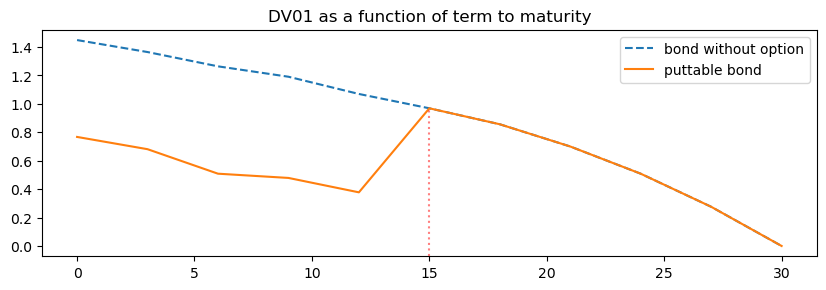

In [388]:
plt.figure(figsize=(10,3),dpi=100)
plt.plot(t,dv01_bond,ls='--',label = 'bond without option')
plt.plot(t,dv01_put_bond,label ='puttable bond')
plt.axvline(x=15,ymax=0.65,color='r',ls=':',alpha=0.5)
plt.title('DV01 as a function of term to maturity')
plt.legend()

The put option enables the investor to sell the bond at the strike price. Hence the value of the puttable bond is always higher than the value of the bond without option till expiry date.

The DV01 of a puttable bond is always less than the bond without option till expiry of the bond. As we get closer to the expiry date, the dv01 of puttable bond increases and after expiry, it is same as the dv01 of the bond. The dv01 of the puttable bond is maximum at the expiry date and decreases after the expiry.